# Analysis of weather effects on Citibike trips

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import our helpers module. appending parent directory ("..") to sys.path might be necessary for helpers to be imported on some systems
import sys

sys.path.insert(0, "..")
import helpers

## Read data
* trips
* weather

In [ ]:
DATA_DIR = "../data/"
WEATHER_DIR = DATA_DIR + "weather/"

In [ ]:
%%time
trips = helpers.get_trips(2019, DATA_DIR)
trips["starttime"] = pd.to_datetime(trips["starttime"])
trips["stoptime"] = pd.to_datetime(trips["stoptime"])

trips

CPU times: user 39.1 s, sys: 24.7 s, total: 1min 3s
Wall time: 1min 8s


,tripduration,starttime,stoptime,startstationid,endstationid,bikeid,usertype,birthyear,gender
0,320,2019-01-01 00:01:47.401,2019-01-01 00:07:07.581,3160,3283,15839,Subscriber,1971,1
1,316,2019-01-01 00:04:43.736,2019-01-01 00:10:00.608,519,518,32723,Subscriber,1964,1
2,591,2019-01-01 00:06:03.997,2019-01-01 00:15:55.438,3171,3154,27451,Subscriber,1987,1
3,2719,2019-01-01 00:07:03.545,2019-01-01 00:52:22.650,504,3709,21579,Subscriber,1990,1
4,303,2019-01-01 00:07:35.945,2019-01-01 00:12:39.502,229,503,35379,Subscriber,1979,1
...,...,...,...,...,...,...,...,...,...
20551512,729,2019-10-31 23:59:12.190,2019-11-01 00:11:21.486,237,311,25725,Subscriber,1995,1
20551513,645,2019-10-31 23:59:17.047,2019-11-01 00:10:02.945,3259,461,39583,Customer,1969,0
20551514,257,2019-10-31 23:59:22.514,2019-11-01 00:03:40.260,3798,505,21240,Subscriber,1985,1
20551515,466,2019-10-31 23:59:23.171,2019-11-01 00:07:09.205,328,361,34916,Subscriber,1989,0


In [ ]:
# read weather
weather = pd.read_csv(WEATHER_DIR + "GHCN-Daily-Cleaned.csv", index_col=0)
weather["DATE"] = pd.to_datetime(weather["DATE"])
weather.set_index(weather["DATE"])
weather

,DATE,PRCP,SNOW,SNWD,TAVG_F,Normal Fog,Heavy Fog,Ice Fog,Fog,Thunder,Haze,Rain
0,2013-01-01,0.0,0.0,0.0,33.0,0,0,0,0,0,0,0
1,2013-01-02,0.0,0.0,0.0,27.5,0,0,0,0,0,1,0
2,2013-01-03,0.0,0.0,0.0,28.0,0,0,0,0,0,0,0
3,2013-01-04,0.0,0.0,0.0,33.5,0,0,0,0,0,0,0
4,2013-01-05,0.0,0.0,0.0,37.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3361,2022-03-16,0.0,0.0,0.0,57.5,0,0,0,0,0,0,0
3362,2022-03-17,2.0,0.0,0.0,49.0,1,1,0,1,0,1,0
3363,2022-03-18,0.0,0.0,0.0,62.0,1,0,0,1,0,1,0
3364,2022-03-19,1.3,0.0,0.0,59.4,1,0,0,1,0,1,0


## Helper Functions

## Weather EDA

In [ ]:
trips_per_day = (
    trips.groupby(trips["starttime"].dt.dayofyear)["tripduration"]
    .count()
    .reset_index()
    .rename(columns={"starttime": "dayofyear", "tripduration": "counttrips"})
)
trips_per_day

,dayofyear,counttrips
0,1,21962
1,2,37797
2,3,41676
3,4,43922
4,5,17432
...,...,...
360,361,31808
361,362,28520
362,363,17968
363,364,12138


In [ ]:
start_2019 = pd.to_datetime("2019-01-01")
end_2019 = pd.to_datetime("2019-12-31")
weather_2019 = weather.loc[
    (weather["DATE"] >= start_2019) & (weather["DATE"] <= end_2019)
]

In [ ]:
w_trips = pd.merge(
    weather_2019,
    trips_per_day,
    left_on=weather_2019["DATE"].dt.dayofyear,
    right_on="dayofyear",
)
w_trips["Snowed on Day"] = w_trips["SNWD"].apply(lambda depth: depth > 0)
w_trips

,DATE,PRCP,SNOW,SNWD,TAVG_F,Normal Fog,Heavy Fog,Ice Fog,Fog,Thunder,Haze,Rain,dayofyear,counttrips,Snowed on Day
0,2019-01-01,1.5,0.0,0.0,48.5,1,0,0,1,0,0,0,1,21962,False
1,2019-01-02,0.0,0.0,0.0,37.5,0,0,0,0,0,0,0,2,37797,False
2,2019-01-03,0.0,0.0,0.0,40.6,0,0,0,0,0,0,0,3,41676,False
3,2019-01-04,0.0,0.0,0.0,41.0,0,0,0,0,0,0,0,4,43922,False
4,2019-01-05,12.7,0.0,0.0,44.0,1,0,0,1,0,0,0,5,17432,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,0.0,0.0,0.0,50.0,0,0,0,0,0,0,0,361,31808,False
361,2019-12-28,0.0,0.0,0.0,47.0,1,0,0,1,0,1,0,362,28520,False
362,2019-12-29,6.4,0.0,0.0,41.5,1,0,0,1,0,0,0,363,17968,False
363,2019-12-30,18.8,0.0,0.0,39.0,1,0,0,1,0,0,0,364,12138,False


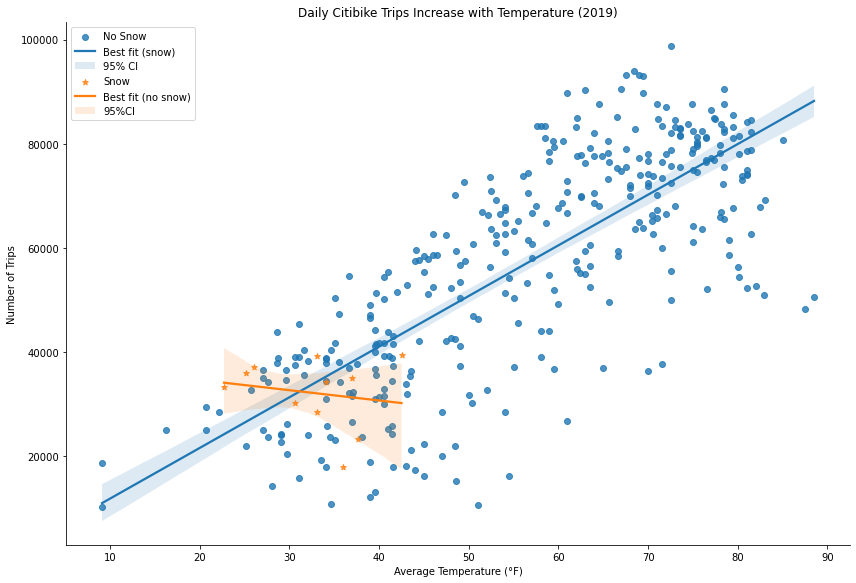

In [ ]:
# g = sns.replot(data = w_trips, x='temp_f', y='counttrips', kind='scatter', height=4, aspect=1.5)
g = sns.lmplot(
    data=w_trips,
    x="TAVG_F",
    y="counttrips",
    hue="Snowed on Day",
    markers=["o", "*"],
    height=8,
    aspect=1.5,
    facet_kws={"legend_out": False},
)
plt.title("Daily Citibike Trips Increase with Temperature (2019)")
plt.xlabel("Average Temperature (°F)")
plt.ylabel("Number of Trips")
plt.legend(
    labels=[
        "No Snow",
        "Best fit (snow)",
        "95% CI",
        "Snow",
        "Best fit (no snow)",
        "95%CI",
    ]
)
plt.show()

In [ ]:
#